# Project (Stock Market Prediction)
---

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Load project data

In [3]:
# body = './data.csv'
data = pd.read_csv('data.csv')
# Print message
original_size = data.shape[0]
print("Data loaded. ({:d} rows)".format(original_size))

Data loaded. (667 rows)


In [4]:
data.head()

,date,signal,spy_close_price
0,20120103,3.107767,127.495
1,20120104,3.107282,127.700
2,20120105,3.099757,128.040
3,20120106,3.134223,127.710
4,20120109,3.135922,128.020


In [5]:
pd.DataFrame(data.isnull().sum(), columns=['numOfNull'])

,numOfNull
date,0
signal,0
spy_close_price,0


#### *There is no missing value*

---
### Convert the date column from type int64 to datetime, and create a column called ordinalTime

In [6]:
# Convert the date column from type int64 to datetime
data['date']= pd.to_datetime(data['date'].astype(str), format='%Y%m%d')
data['ordinalTime'] = data['date'].map(datetime.toordinal)
data.head()

,date,signal,spy_close_price,ordinalTime
0,2012-01-03,3.107767,127.495,734505
1,2012-01-04,3.107282,127.700,734506
2,2012-01-05,3.099757,128.040,734507
3,2012-01-06,3.134223,127.710,734508
4,2012-01-09,3.135922,128.020,734511


In [7]:
data.describe()

,signal,spy_close_price,ordinalTime
count,667.000000,667.000000,667.000000
mean,5.166603,163.169369,734991.910045
std,23.392818,39.210384,281.872457
min,-3.802670,127.495000,734505.000000
25%,3.418083,140.880000,734744.500000
50%,3.893689,159.750000,734996.000000
75%,4.408313,181.500000,735234.500000
max,432.961165,710.310000,735474.000000


#### Through data description, obviously there are some suspious data

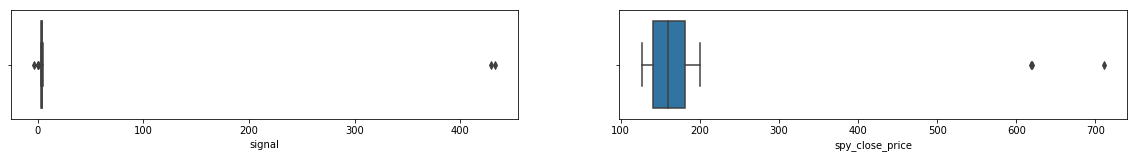

In [8]:
import warnings
warnings.filterwarnings("ignore")
fig = plt.figure(figsize=(20, 2))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.boxplot(x = data.iloc[:,1], ax = ax1)
sns.boxplot(x = data.iloc[:,2], ax = ax2)
plt.show()

#### Such outliers are:

In [9]:
data.query('spy_close_price >= 300 | signal <= 2 | signal >= 6')

,date,signal,spy_close_price,ordinalTime
303,2013-03-26,-3.802670,156.1900,734953
421,2013-09-12,4.193204,618.9500,735123
422,2013-09-13,4.143689,619.3300,735124
423,2013-09-16,4.124515,710.3100,735127
459,2013-11-05,429.514563,176.2700,735177
460,2013-11-06,432.961165,177.1700,735178
570,2014-04-14,0.004560,182.9401,735337
571,2014-04-15,0.454976,184.2000,735338
572,2014-04-16,0.455898,186.1250,735339


---
### Clean the data by removing all outliers

In [10]:
# Finding Quantiles and Interquantiles
spy_q1, spy_q3 = data['spy_close_price'].quantile(.25), data['spy_close_price'].quantile(.75)
sig_q1, sig_q3 = data['signal'].quantile(.25), data['signal'].quantile(.75)
spy_iqr, sig_iqr = spy_q3 - spy_q1, sig_q3 - sig_q1 

spy_upper_threshold, spy_lower_threshold = spy_q3 + 1.5 * spy_iqr, spy_q1 - 1.5 * spy_iqr
sig_upper_threshold, sig_lower_threshold = sig_q3 + 1.5 * sig_iqr, sig_q1 - 1.5 * sig_iqr

data = data[(data['spy_close_price'] < spy_upper_threshold) & (data['spy_close_price'] > spy_lower_threshold) &
           (data['signal'] < sig_upper_threshold) & (data['signal'] > sig_lower_threshold)]

# Print message
print("Data cleaned. ({:d} rows, {:d} rows removed)".format(data.shape[0], original_size - data.shape[0]))

Data cleaned. (658 rows, 9 rows removed)


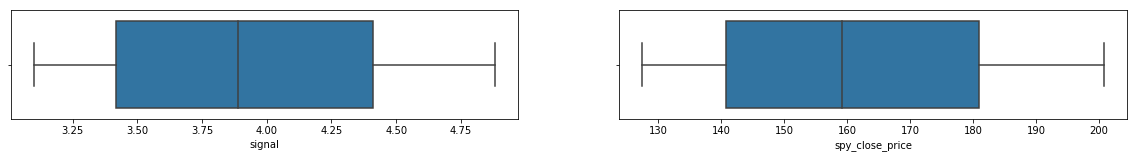

In [11]:
import warnings
warnings.filterwarnings("ignore")
fig = plt.figure(figsize=(20, 2))
ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
sns.boxplot(x = data.iloc[:,1], ax = ax1)
sns.boxplot(x = data.iloc[:,2], ax = ax2)
plt.show()

In [12]:
data.describe()

,signal,spy_close_price,ordinalTime
count,658.000000,658.000000,658.000000
mean,3.911967,160.824444,734989.221884
std,0.525500,21.488326,282.486544
min,3.099757,127.495000,734505.000000
25%,3.419053,140.817500,734742.250000
50%,3.890291,159.245000,734990.500000
75%,4.409072,180.985000,735233.750000
max,4.881311,200.710000,735474.000000


#### The correlation of cleaned data is given as follow:

In [13]:
data.corr()

,signal,spy_close_price,ordinalTime
signal,1.000000,0.995078,0.978380
spy_close_price,0.995078,1.000000,0.978789
ordinalTime,0.978380,0.978789,1.000000


---
### Visualize Data

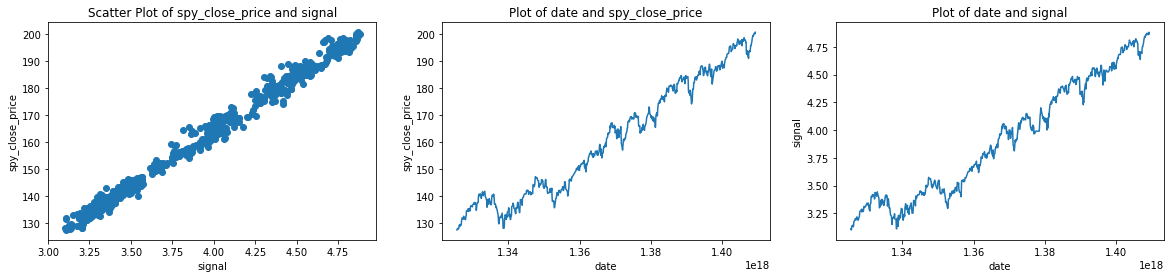

In [14]:
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(131)
ax.scatter(data['signal'], data['spy_close_price'])
ax.set(title='Scatter Plot of spy_close_price and signal', ylabel='spy_close_price', xlabel='signal')

ax = fig.add_subplot(132)
ax.plot(data['date'], data['spy_close_price'])
ax.set(title='Plot of date and spy_close_price', ylabel='spy_close_price', xlabel='date')

ax = fig.add_subplot(133)
ax.plot(data['date'], data['signal'])
ax.set(title='Plot of date and signal', ylabel='signal', xlabel='date')
plt.show()

---
### Normalize signal, spy_close_price, and ordinalTime

In [15]:
sig_min, sig_max, spy_min, spy_max, ord_min, ord_max = 3, 5, 100, 250, data['ordinalTime'].min(), data['ordinalTime'].max() + 10

data['signal'] = (data['signal'] - sig_min) / (sig_max - sig_min)
data['spy_close_price'] = (data['spy_close_price'] - spy_min) / (spy_max - spy_min)
data['ordinalTime'] = (data['ordinalTime'] - ord_min) / (ord_max - ord_min)

data.head()

,date,signal,spy_close_price,ordinalTime
0,2012-01-03,0.053883,0.183300,0.000000
1,2012-01-04,0.053641,0.184667,0.001021
2,2012-01-05,0.049879,0.186933,0.002043
3,2012-01-06,0.067112,0.184733,0.003064
4,2012-01-09,0.067961,0.186800,0.006129


---
## *Analysis of the predictive power of signal with respect to spy_close_price*

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [17]:
data_train, data_test = data[data['date'] < '2014-01-01'], data[data['date'] >= '2014-01-01']

X_train, y_train = data_train.drop(['spy_close_price', 'date'], axis=1), data_train['spy_close_price']
X_test, y_test = data_test.drop(['spy_close_price', 'date'], axis=1), data_test['spy_close_price']

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep='\n')

(493, 2)
(493,)
(165, 2)
(165,)


In [18]:
def showPredictPlot(X_test, predResult, data_test):
    temp = X_test.copy()
    temp['predicted_spy_close_price'] = predResult
    fig = plt.figure(figsize = (20, 5))
    plt.plot('ordinalTime', 'spy_close_price', data = data_test, linewidth = 2)
    plt.plot('ordinalTime', 'predicted_spy_close_price', data = temp, color = 'red', linewidth = 2)
    plt.legend()
    plt.show()
    
def printReport(name, score, test_score, reg):
    print(name, 'Score: \n', score, '\n')
    print(name, 'Test Score: \n', test_score)
    print('\nCoefficient: \n', reg.coef_, '\n\nIntercept: \n', reg.intercept_)

In [19]:
reg_performance = {'Model':[], 'Score':[]}

---
### Lasso Regression

Lasso Regression Score: 
 0.0 

Lasso Regression Test Score: 
 -3766.468

Coefficient: 
 [ 0.  0.] 

Intercept: 
 0.341572305612


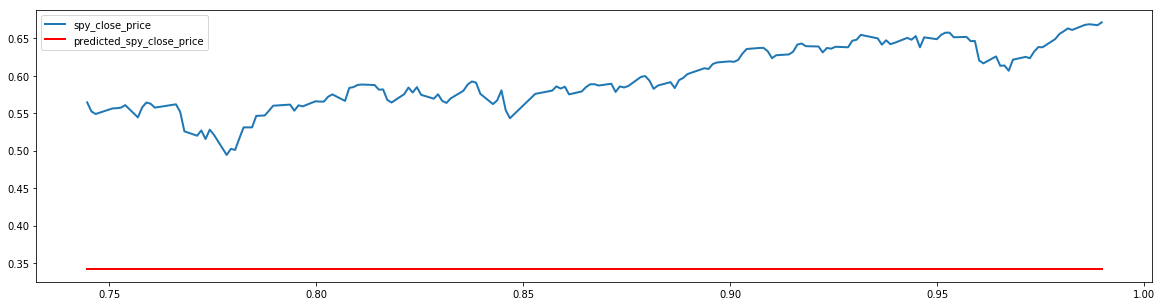

In [20]:
from sklearn.linear_model import Lasso

lassoReg = Lasso(alpha = 0.5).fit(X_train, y_train)
lassoReg_predicted = lassoReg.predict(X_test)

lassoReg_score, lassoReg_score_test = round(lassoReg.score(X_train, y_train) * 100, 2), round(lassoReg.score(X_test, y_test) * 100, 3)

if 'Lasso' not in reg_performance['Model']:
    reg_performance['Model'].append('Lasso')
    reg_performance['Score'].append(lassoReg_score_test)

# Print Report
printReport('Lasso Regression', lassoReg_score, lassoReg_score_test, lassoReg)
showPredictPlot(X_test, lassoReg_predicted, data_test)

---
### Ridge Regression

Ridge Regression Score: 
 98.48 

Ridge Regression Test Score: 
 83.345

Coefficient: 
 [ 0.48893937  0.0457446 ] 

Intercept: 
 0.158875529423


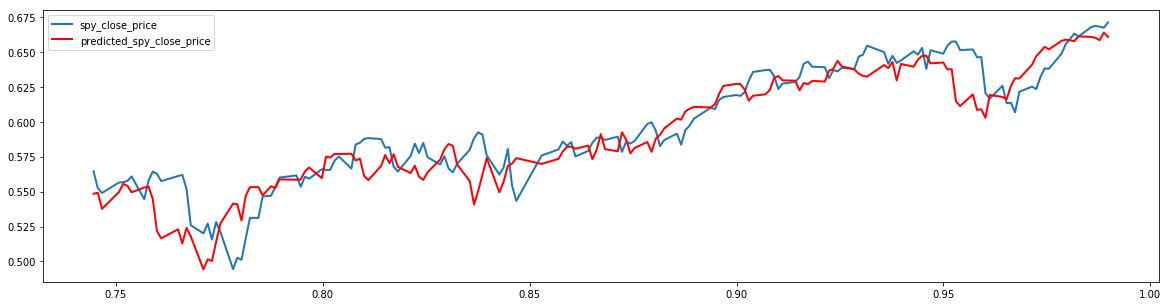

In [21]:
from sklearn.linear_model import Ridge

ridgeReg = Ridge(alpha = 0.0001, fit_intercept = True, normalize = True).fit(X_train, y_train)
ridgeReg_predicted = ridgeReg.predict(X_test)

ridgeReg_score, ridgeReg_score_test = round(ridgeReg.score(X_train, y_train) * 100, 2), round(ridgeReg.score(X_test, y_test) * 100, 3)

if 'Ridge' not in reg_performance['Model']:
    reg_performance['Model'].append('Ridge')
    reg_performance['Score'].append(ridgeReg_score_test)

# Print Report
printReport('Ridge Regression', ridgeReg_score, ridgeReg_score_test, ridgeReg)
showPredictPlot(X_test, ridgeReg_predicted, data_test)

---
### Linear Regression

Linear Regression Score: 
 98.48 

Linear Regression Test Score: 
 83.347

Coefficient: 
 [ 0.48940946  0.045359  ] 

Intercept: 
 0.158858559765


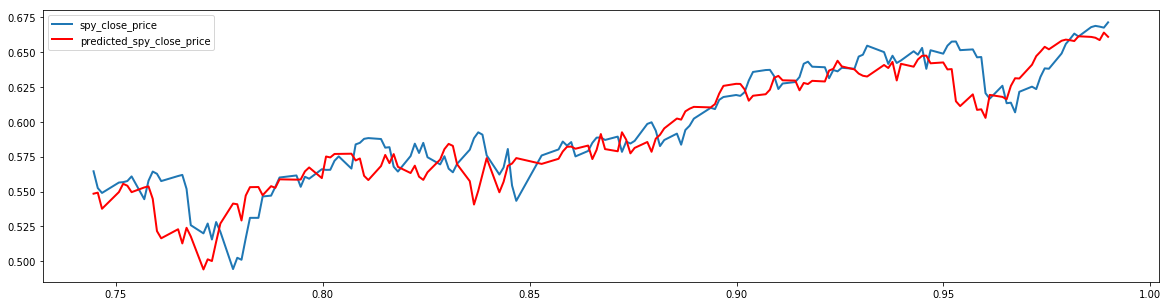

In [22]:
from sklearn.linear_model import LinearRegression

linearReg = LinearRegression().fit(X_train, y_train)
linearReg_predicted = linearReg.predict(X_test)

linear_score, linear_score_test = round(linearReg.score(X_train, y_train) * 100, 2), round(linearReg.score(X_test, y_test) * 100, 3)

if 'Linear' not in reg_performance['Model']:
    reg_performance['Model'].append('Linear')
    reg_performance['Score'].append(linear_score_test)

# Print Report
printReport('Linear Regression', linear_score, linear_score_test, linearReg)
showPredictPlot(X_test, linearReg_predicted, data_test)

---
### Bayesian ARD Regression

ARD Regression Score: 
 98.48 

ARD Regression Test Score: 
 83.311

Coefficient: 
 [ 0.49098509  0.04389948] 

Intercept: 
 0.158863407922


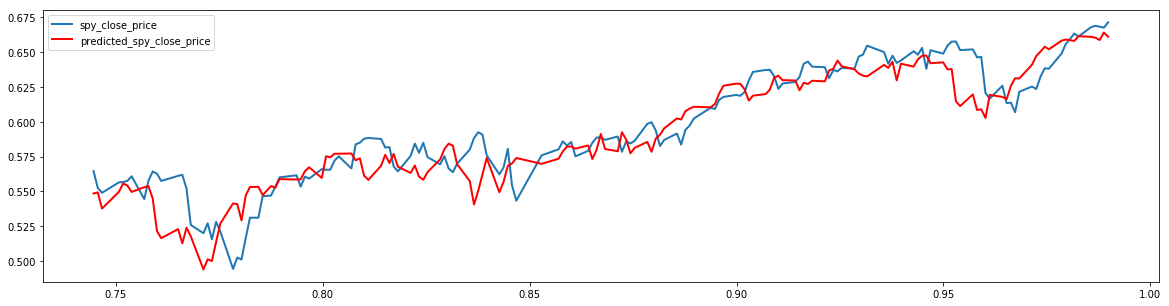

In [23]:
from sklearn.linear_model import ARDRegression

ardReg = ARDRegression().fit(X_train, y_train)
ardReg_predicted = ardReg.predict(X_test)

ardReg_score, ardReg_score_test = round(ardReg.score(X_train, y_train) * 100, 2), round(ardReg.score(X_test, y_test) * 100, 3)

if 'ARD' not in reg_performance['Model']:
    reg_performance['Model'].append('ARD')
    reg_performance['Score'].append(ardReg_score_test)

# Print Report
printReport('ARD Regression', ardReg_score, ardReg_score_test, ardReg)
showPredictPlot(X_test, ardReg_predicted, data_test)

---
## Using only date to predict spy_close_price

In [24]:
X_train_dateOnly, y_train = data_train.drop(['spy_close_price', 'signal', 'date'], axis=1), data_train['spy_close_price']
X_test_dateOnly, y_test = data_test.drop(['spy_close_price', 'signal', 'date'], axis=1), data_test['spy_close_price']

print (X_train_dateOnly.shape, y_train.shape, X_test_dateOnly.shape, y_test.shape, sep='\n')

(493, 1)
(493,)
(165, 1)
(165,)


Linear Regression Score: 
 90.9 

Linear Regression Test Score: 
 30.94

Coefficient: 
 [ 0.45156383] 

Intercept: 
 0.174766313678


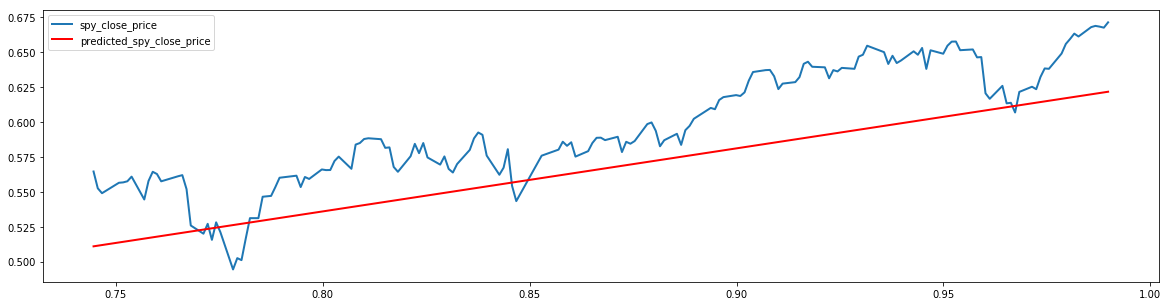

In [25]:
linearReg = LinearRegression()
linearReg.fit(X_train_dateOnly, y_train)
linearReg_predicted = linearReg.predict(X_test_dateOnly)

linear_score, linear_score_test = round(linearReg.score(X_train_dateOnly, y_train) * 100, 2), round(linearReg.score(X_test_dateOnly, y_test) * 100, 2)

printReport('Linear Regression', linear_score, linear_score_test, linearReg)
showPredictPlot(X_test, linearReg_predicted, data_test)

<b>*Apparently this gives a poor prediction.*</b>

---
# Recurrent Neural Networks

#### In this section, I am using the spy_close_price from previous days to predict future spy_close_price

In [27]:
import os
import keras
import tensorflow as tf
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, LSTM, GRU, Input, SimpleRNN

Using TensorFlow backend.


### Respliting data with proper batch_size

In [28]:
batch_size = 16
epochs = 500
timesteps = 10
train_percentage = 0.75
rnn_performance = {'Model':[], 'RMSE':[], 'MAE':[]}

In [29]:
def get_train_size(dataframe, batch_size, train_percent):
    length, max_length = int(dataframe.shape[0] * train_percent), 0
    for x in range(length, length - 100, -1): 
        if (x % batch_size == 0):
            max_length = x
            break
    return max_length

def get_test_length(dataframe, batch_size, upper):
    test_length = 0
    for x in range(len(dataframe) - timesteps * 2, upper, -1): 
        modulo = (x - upper) % batch_size
        if (modulo == 0):
            test_length = x
            break
    return test_length

In [30]:
train_size = get_train_size(data, batch_size, train_percentage)
upper_train = train_size + timesteps * 2

test_size = get_test_length(data, batch_size, upper_train)
upper_test = test_size + timesteps * 2

print('Train Size:', train_size, '\nTest Size:', test_size)

Train Size: 480 
Test Size: 628


In [31]:
data_lstm_train, data_lstm_test = data[0:upper_train], data[upper_train: upper_test]
training_set, test_set = data_lstm_train.iloc[:, 2:3].values, data_lstm_test.iloc[:, 2:3].values # spy_close_price

print('Train:', training_set.shape, '\nTest:', test_set.shape)

Train: (500, 1) 
Test: (148, 1)


### Creating a data structure with timesteps

#### Train

In [32]:
X_train_lstm, y_train_lstm = [], []

# Creating a data structure with n timesteps
for i in range(timesteps, train_size + timesteps): 
    X_train_lstm.append(training_set[i - timesteps : i, 0])
    y_train_lstm.append(training_set[i : i + timesteps, 0])

# Reshaping
X_train_lstm, y_train_lstm = np.array(X_train_lstm), np.array(y_train_lstm)
X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
y_train_lstm = np.reshape(y_train_lstm, (y_train_lstm.shape[0], y_train_lstm.shape[1], 1))
print(X_train_lstm.shape, y_train_lstm.shape, sep='\n')

(480, 10, 1)
(480, 10, 1)


#### Test

In [33]:
X_test_lstm = []
for i in range(timesteps, test_size - upper_train + timesteps):
    X_test_lstm.append(test_set[i - timesteps : i, 0])

# Reshaping
X_test_lstm = np.array(X_test_lstm)
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], 1))
print(X_test_lstm.shape)

(128, 10, 1)


---
### Functions for prediction

In [34]:
def pred3dim_to_2dim(predicted):
    predicted_test = np.reshape(predicted, (predicted.shape[0], predicted.shape[1]))
    y_test = []
    for j in range(0, test_size - upper_train - timesteps):
        y_test = np.append(y_test, predicted_test[j, timesteps - 1])
    return np.reshape(y_test, (y_test.shape[0], 1))

def evaluateModel(pred, test):
    rmse, mae = math.sqrt(mean_squared_error(pred, test)), mean_absolute_error(pred, test)
    print('Model Evaluation:', '\n\tRoot mean squared error:', rmse, '\n\tMean absolute error:', mae)
    return rmse, mae

def visualizeModel(test_data, y_test, timestep, info='LSTM'):
    test_data = test_data * (spy_max - spy_min) + spy_min
    y_test = y_test * (spy_max - spy_min) + spy_min
    fig = plt.figure(figsize=(20, 4))
    plt.plot(test_data[timestep : len(y_test)], label = 'Actual')
    plt.plot(y_test[0: len(y_test) - timestep], color = 'red', label = 'Predicted')
    plt.title('Stock Market Prediction - ' + info)
    plt.xlabel('Time')
    plt.ylabel('spy_close_price')
    plt.legend()
    plt.show()

def full_prediction(optimizer, loss, model_type = 'LSTM', unit1 = 16, unit2 = 16, print_summary=True, activation=None):
    # Build Model
    inputs_1, output_1, layer_1, layer_2, model = Input(batch_shape=(batch_size, timesteps, 1)), None, None, None, None
    if model_type == 'LSTM':
        layer_1 = LSTM(unit1, stateful=True, return_sequences=True)(inputs_1)
        layer_2 = LSTM(unit2, stateful=True, return_sequences=True)(layer_1)
        model_type = model_type + '({}, {})'.format(unit1, unit2)
    elif model_type == 'GRU':
        layer_2 = GRU(1, stateful=True, return_sequences=True)(inputs_1)
    elif model_type == 'SimpleRNN':
        layer_2 = SimpleRNN(1, stateful=True, return_sequences=True)(inputs_1)
    else:
        print('Invalid Model Type')
        return
    
    output_1 = Dense(units = 1, activation=activation)(layer_2)
    model = Model(inputs=inputs_1, outputs = output_1)
    model.compile(optimizer = optimizer, loss = loss)
    if print_summary:
        model.summary()
        print()
    
    # Epochs
    his_loss, best_epoch = 100.0, 0
    for i in range(epochs):
        history = model.fit(X_train_lstm, y_train_lstm, shuffle = False, epochs = 1, batch_size = batch_size, verbose = 0)
        if history.history['loss'][0] < his_loss:
            his_loss, best_epoch = history.history['loss'][0], i
            model.save_weights('bestmodel.h5')
        model.reset_states()
        
    print(epochs, ' Epochs Finished. (Best: ', int(best_epoch + 1), ')\n', sep='')
    
    if os.path.exists('bestmodel.h5'): # revert to the best model if exsists
        model.load_weights('bestmodel.h5') 
        os.remove('bestmodel.h5')
    
    # Prediction
    model_predicted = model.predict(X_test_lstm, batch_size = batch_size)
    model.reset_states()
    y_test_model = pred3dim_to_2dim(model_predicted)
    
    # Evaluate
    rmse, mae = evaluateModel(test_set[timesteps : len(y_test_model)], y_test_model[0: len(y_test_model) - timesteps])
    model_name = model_type + '_' + optimizer + '_' + loss + '_'
    if activation is None:
        model_name += 'None'
    else:
        model_name += activation
    if model_name not in rnn_performance['Model']:
        rnn_performance['Model'].append(model_name)
        rnn_performance['RMSE'].append(rmse)
        rnn_performance['MAE'].append(mae)
    else:
        index = rnn_performance['Model'].index(model_name)
        rnn_performance['RMSE'][index] = rmse
        rnn_performance['MAE'][index] = mae
    
    # Visualization
    visualizeModel(test_set.copy(), y_test_model.copy(), timestep = timesteps, info = model_name)
    
    # Free
    del inputs_1, output_1, layer_1, layer_2, model, model_predicted, y_test_model

---
## LSTM

#### Using Optimizer: Adam

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (16, 10, 1)               0         
_________________________________________________________________
lstm_1 (LSTM)                (16, 10, 10)              480       
_________________________________________________________________
lstm_2 (LSTM)                (16, 10, 10)              840       
_________________________________________________________________
dense_1 (Dense)              (16, 10, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________

500 Epochs Finished. (Best: 497)

Model Evaluation: 
	Root mean squared error: 0.01283809538558579 
	Mean absolute error: 0.00960938702942


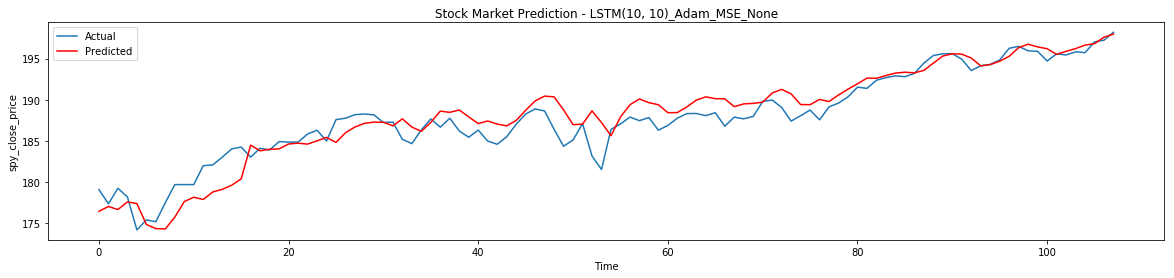

In [35]:
full_prediction(optimizer = 'Adam', loss = 'MSE', model_type = 'LSTM', unit1 = 10, unit2 = 10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (16, 10, 1)               0         
_________________________________________________________________
lstm_3 (LSTM)                (16, 10, 10)              480       
_________________________________________________________________
lstm_4 (LSTM)                (16, 10, 16)              1728      
_________________________________________________________________
dense_2 (Dense)              (16, 10, 1)               17        
Total params: 2,225
Trainable params: 2,225
Non-trainable params: 0
_________________________________________________________________

500 Epochs Finished. (Best: 486)

Model Evaluation: 
	Root mean squared error: 0.012577105447632502 
	Mean absolute error: 0.0103719230506


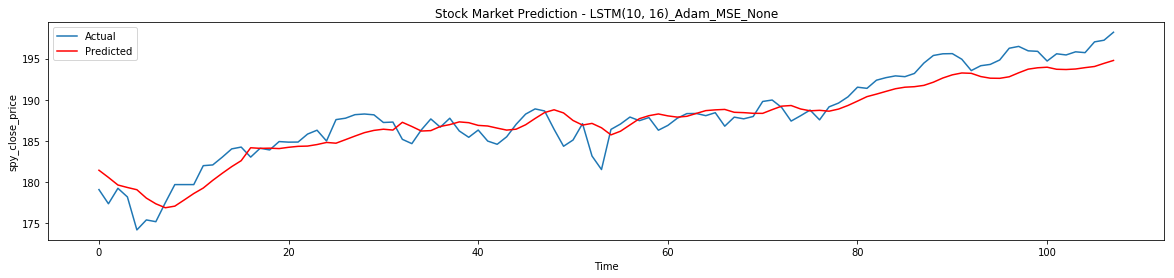

In [36]:
full_prediction(optimizer = 'Adam', loss = 'MSE', model_type = 'LSTM', unit1 = 10, unit2 = 16)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (16, 10, 1)               0         
_________________________________________________________________
lstm_5 (LSTM)                (16, 10, 16)              1152      
_________________________________________________________________
lstm_6 (LSTM)                (16, 10, 10)              1080      
_________________________________________________________________
dense_3 (Dense)              (16, 10, 1)               11        
Total params: 2,243
Trainable params: 2,243
Non-trainable params: 0
_________________________________________________________________

500 Epochs Finished. (Best: 492)

Model Evaluation: 
	Root mean squared error: 0.03158778753049518 
	Mean absolute error: 0.0281142376784


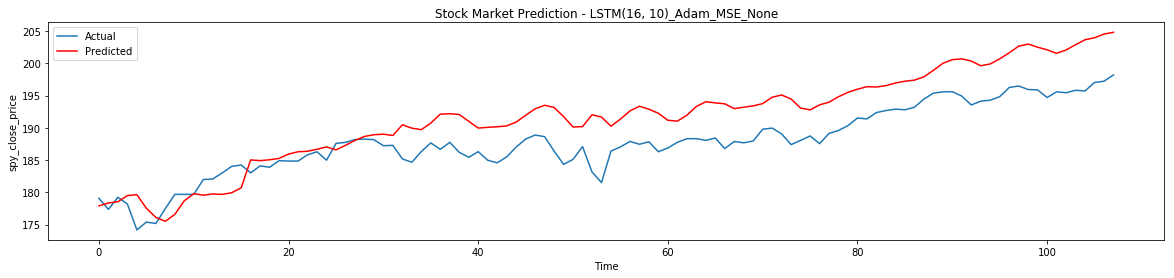

In [37]:
full_prediction(optimizer = 'Adam', loss = 'MSE', model_type = 'LSTM', unit1 = 16, unit2 = 10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (16, 10, 1)               0         
_________________________________________________________________
lstm_7 (LSTM)                (16, 10, 5)               140       
_________________________________________________________________
lstm_8 (LSTM)                (16, 10, 10)              640       
_________________________________________________________________
dense_4 (Dense)              (16, 10, 1)               11        
Total params: 791
Trainable params: 791
Non-trainable params: 0
_________________________________________________________________

500 Epochs Finished. (Best: 500)

Model Evaluation: 
	Root mean squared error: 0.018831250577950133 
	Mean absolute error: 0.0137338912274


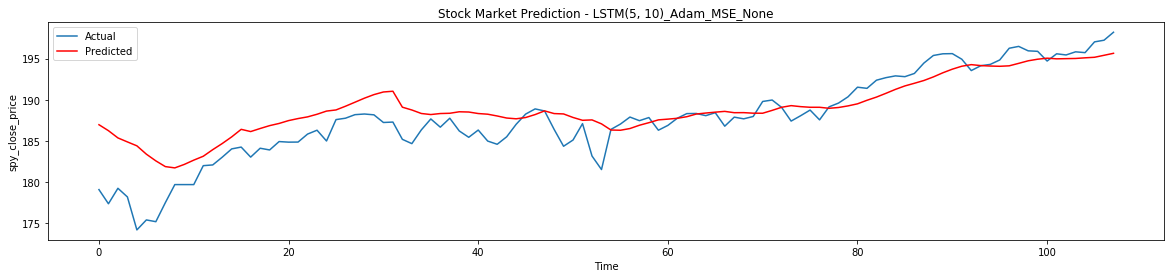

In [38]:
full_prediction(optimizer = 'Adam', loss = 'MSE', model_type = 'LSTM', unit1 = 5, unit2 = 10)

#### *It appear when using unit1 = 10, unit2 = 10 gives lowest error*

500 Epochs Finished. (Best: 81)

Model Evaluation: 
	Root mean squared error: 0.02532785828703532 
	Mean absolute error: 0.0183357964802


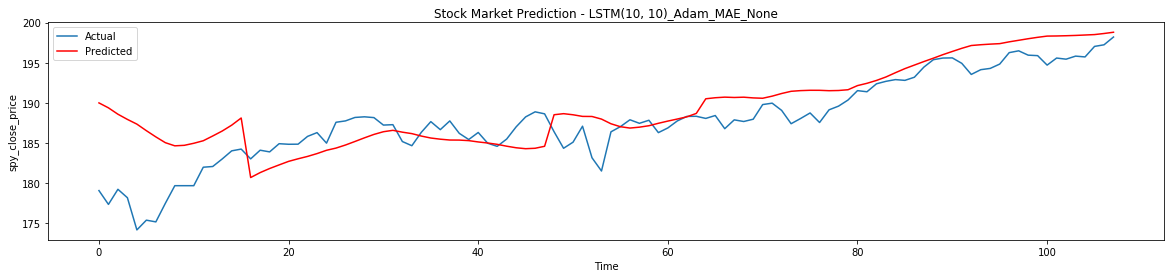

In [39]:
full_prediction(optimizer = 'Adam', loss = 'MAE', model_type = 'LSTM', unit1 = 10, unit2 = 10, print_summary = False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (16, 10, 1)               0         
_________________________________________________________________
lstm_11 (LSTM)               (16, 10, 10)              480       
_________________________________________________________________
lstm_12 (LSTM)               (16, 10, 10)              840       
_________________________________________________________________
dense_6 (Dense)              (16, 10, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________

500 Epochs Finished. (Best: 496)

Model Evaluation: 
	Root mean squared error: 0.07039809780673474 
	Mean absolute error: 0.0649631452822


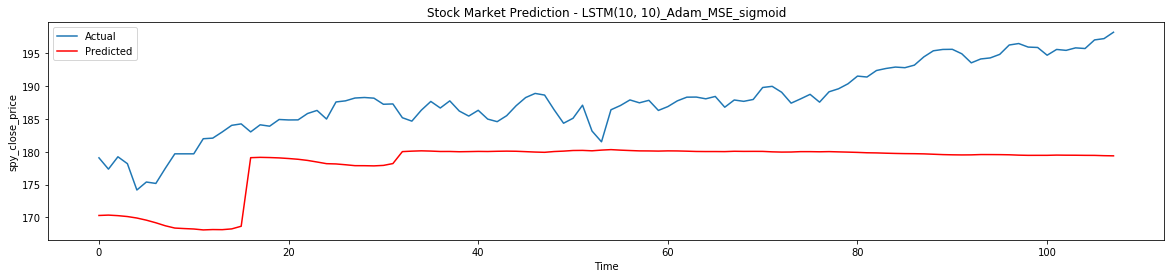

In [40]:
full_prediction(optimizer = 'Adam', loss = 'MSE', model_type = 'LSTM', unit1 = 10, unit2 = 10, activation = 'sigmoid')

---
#### Using Optimizer: Adadelta

500 Epochs Finished. (Best: 442)

Model Evaluation: 
	Root mean squared error: 0.029898116037167057 
	Mean absolute error: 0.025357127257


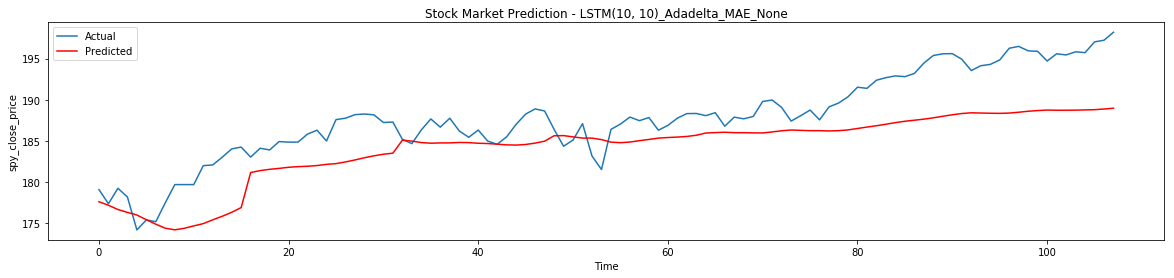

In [41]:
full_prediction(optimizer = 'Adadelta', loss = 'MAE', model_type = 'LSTM', unit1 = 10, unit2 = 10, print_summary = False)

500 Epochs Finished. (Best: 500)

Model Evaluation: 
	Root mean squared error: 0.01451571374972454 
	Mean absolute error: 0.0110041558759


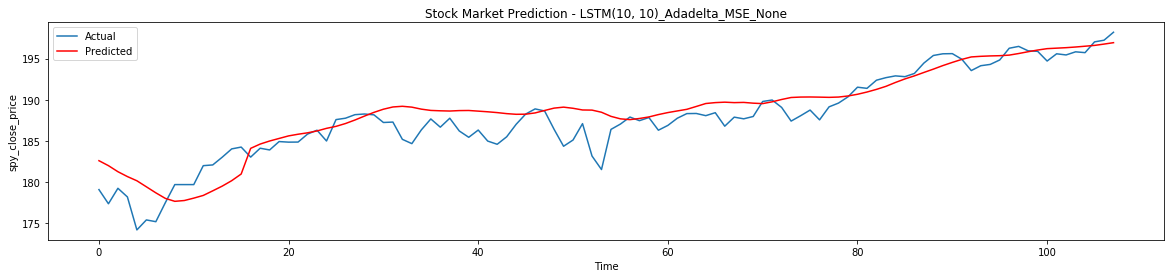

In [42]:
full_prediction(optimizer = 'Adadelta', loss = 'MSE', model_type = 'LSTM', unit1 = 10, unit2 = 10, print_summary = False)

500 Epochs Finished. (Best: 426)

Model Evaluation: 
	Root mean squared error: 0.08803638819680518 
	Mean absolute error: 0.0802838075533


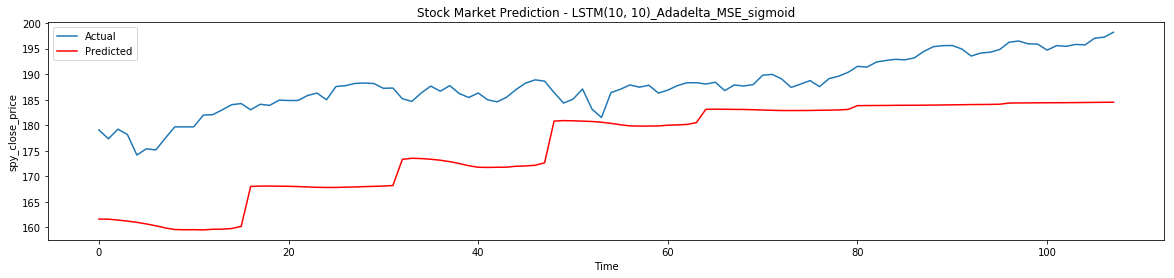

In [44]:
full_prediction(optimizer = 'Adadelta', loss = 'MSE', model_type = 'LSTM', unit1 = 10, unit2 = 10, print_summary = False, activation = 'sigmoid')

---
#### Using Optimizer: RMSprop

500 Epochs Finished. (Best: 227)

Model Evaluation: 
	Root mean squared error: 0.015113299496494642 
	Mean absolute error: 0.0122437541436


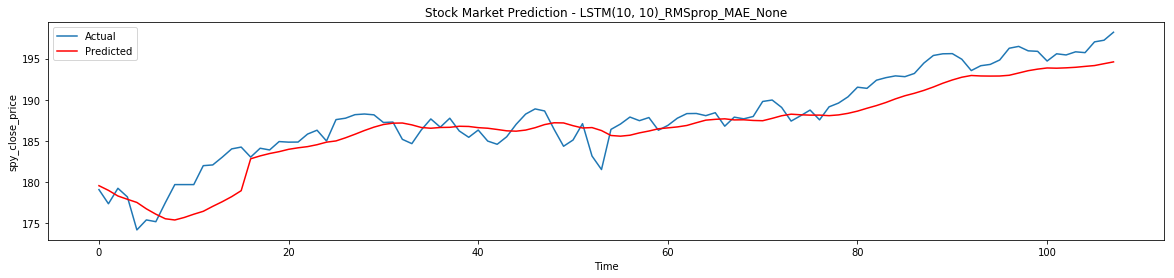

In [45]:
full_prediction(optimizer = 'RMSprop', loss = 'MAE', model_type = 'LSTM', unit1 = 10, unit2 = 10, print_summary = False)

500 Epochs Finished. (Best: 214)

Model Evaluation: 
	Root mean squared error: 0.015056352156894435 
	Mean absolute error: 0.0122977821201


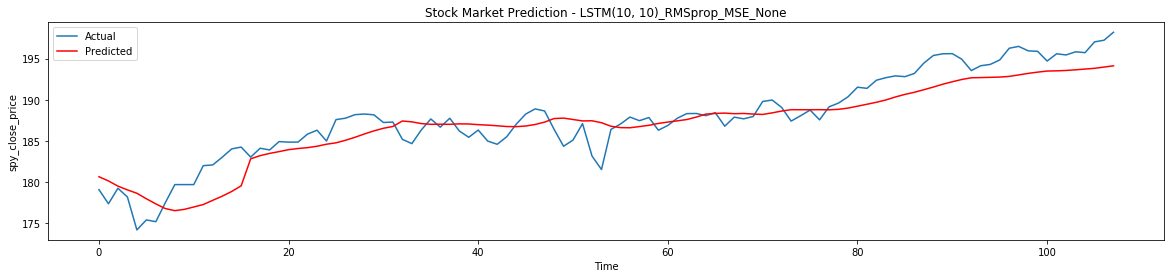

In [46]:
full_prediction(optimizer = 'RMSprop', loss = 'MSE', model_type = 'LSTM', unit1 = 10, unit2 = 10, print_summary = False)

500 Epochs Finished. (Best: 400)

Model Evaluation: 
	Root mean squared error: 0.06026661620760574 
	Mean absolute error: 0.0543380050237


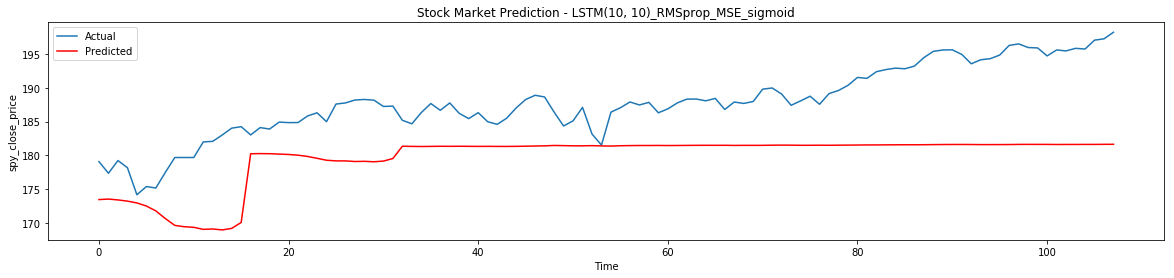

In [47]:
full_prediction(optimizer = 'RMSprop', loss = 'MSE', model_type = 'LSTM', unit1 = 10, unit2 = 10, print_summary = False, activation = 'sigmoid')

---
#### Using Optimizer: Nadam

500 Epochs Finished. (Best: 496)

Model Evaluation: 
	Root mean squared error: 0.014221764635332161 
	Mean absolute error: 0.0114411661789


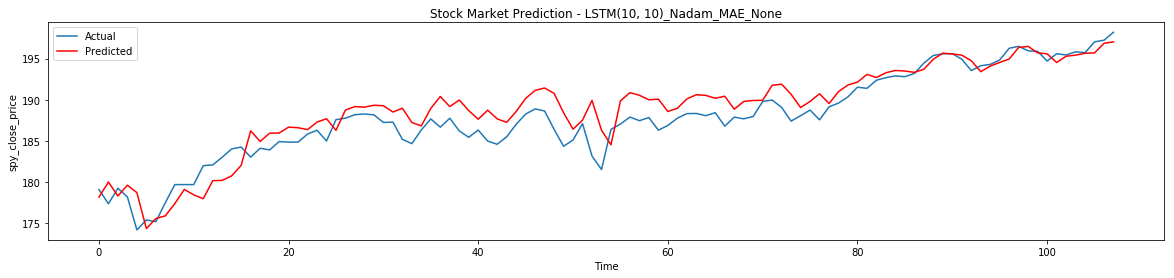

In [48]:
full_prediction(optimizer = 'Nadam', loss = 'MAE', model_type = 'LSTM', unit1 = 10, unit2 = 10, print_summary = False)

500 Epochs Finished. (Best: 473)

Model Evaluation: 
	Root mean squared error: 0.03392193822996542 
	Mean absolute error: 0.0286449995402


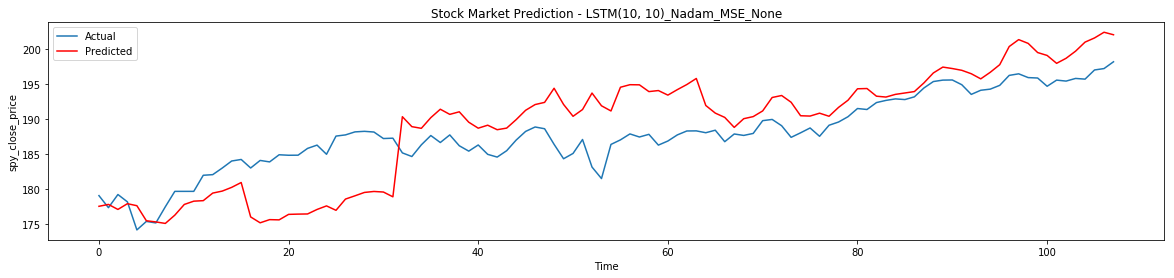

In [49]:
full_prediction(optimizer = 'Nadam', loss = 'MSE', model_type = 'LSTM', unit1 = 10, unit2 = 10, print_summary = False)

500 Epochs Finished. (Best: 300)

Model Evaluation: 
	Root mean squared error: 0.05866327695150483 
	Mean absolute error: 0.0529069378744


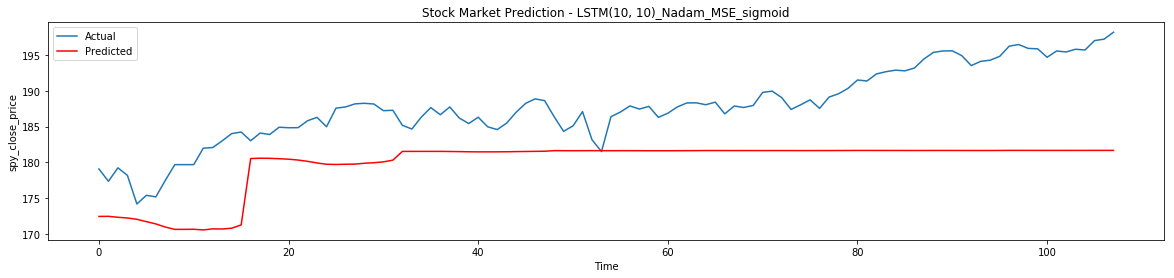

In [50]:
full_prediction(optimizer = 'Nadam', loss = 'MSE', model_type = 'LSTM', unit1 = 10, unit2 = 10, print_summary = False, activation = 'sigmoid')

---
## Gated Recurrent Unit
#### Using Optimizer: Adadelta

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (16, 10, 1)               0         
_________________________________________________________________
gru_1 (GRU)                  (16, 10, 1)               9         
_________________________________________________________________
dense_17 (Dense)             (16, 10, 1)               2         
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________

500 Epochs Finished. (Best: 276)

Model Evaluation: 
	Root mean squared error: 0.013454671412449312 
	Mean absolute error: 0.0101158321468


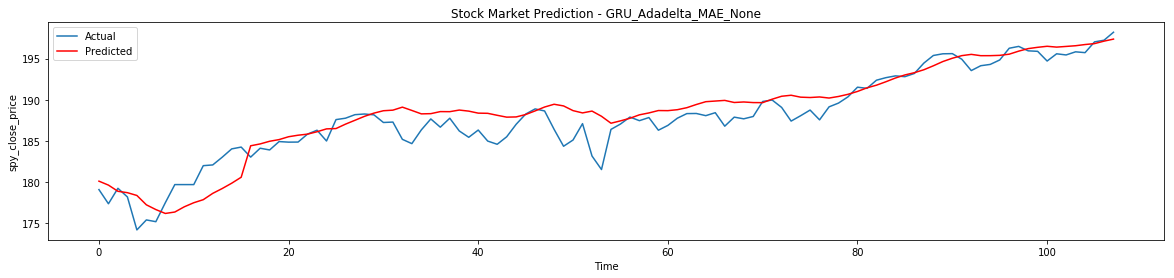

In [51]:
full_prediction(optimizer = 'Adadelta', loss = 'MAE', model_type = 'GRU')

500 Epochs Finished. (Best: 340)

Model Evaluation: 
	Root mean squared error: 0.012295808164719672 
	Mean absolute error: 0.010039100925


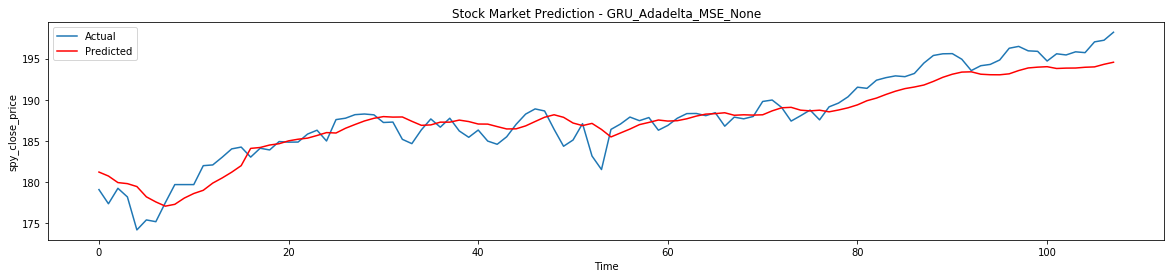

In [52]:
full_prediction(optimizer = 'Adadelta', loss = 'MSE', model_type = 'GRU', print_summary = False)

500 Epochs Finished. (Best: 500)

Model Evaluation: 
	Root mean squared error: 0.012838346476309716 
	Mean absolute error: 0.00964917784108


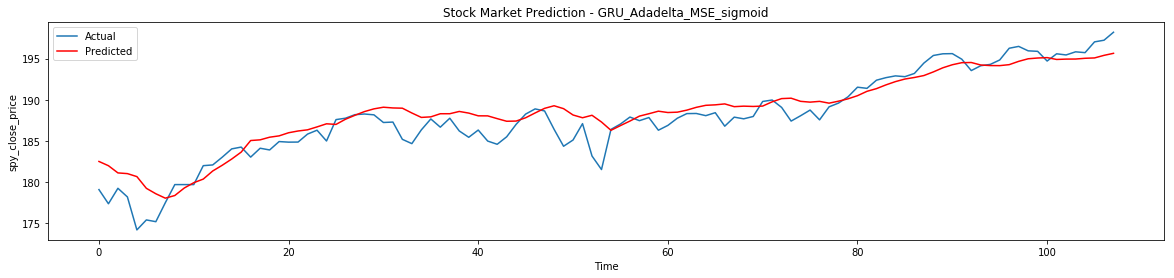

In [53]:
full_prediction(optimizer = 'Adadelta', loss = 'MSE', model_type = 'GRU', print_summary = False, activation='sigmoid')

500 Epochs Finished. (Best: 1)

Model Evaluation: 
	Root mean squared error: 0.5864462986560726 
	Mean absolute error: 0.585400123457


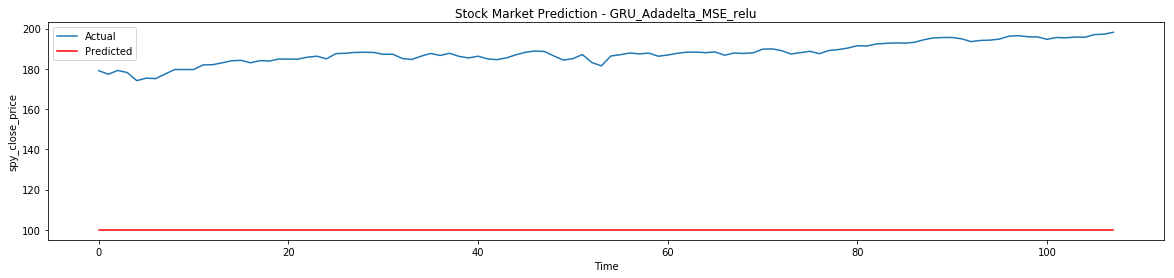

In [54]:
full_prediction(optimizer = 'Adadelta', loss = 'MSE', model_type = 'GRU', print_summary = False, activation='relu')

---
#### Using Optimizer: Adam

500 Epochs Finished. (Best: 387)

Model Evaluation: 
	Root mean squared error: 0.028233317789886143 
	Mean absolute error: 0.0224651342226


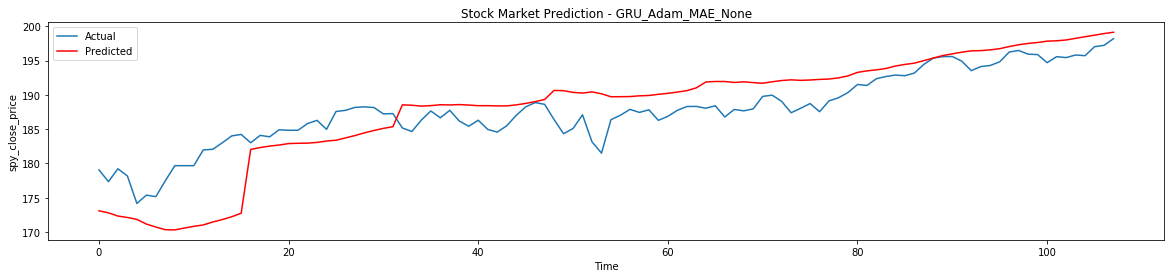

In [55]:
full_prediction(optimizer = 'Adam', loss = 'MAE', model_type = 'GRU', print_summary = False)

500 Epochs Finished. (Best: 488)

Model Evaluation: 
	Root mean squared error: 0.025133463348567933 
	Mean absolute error: 0.0186804276941


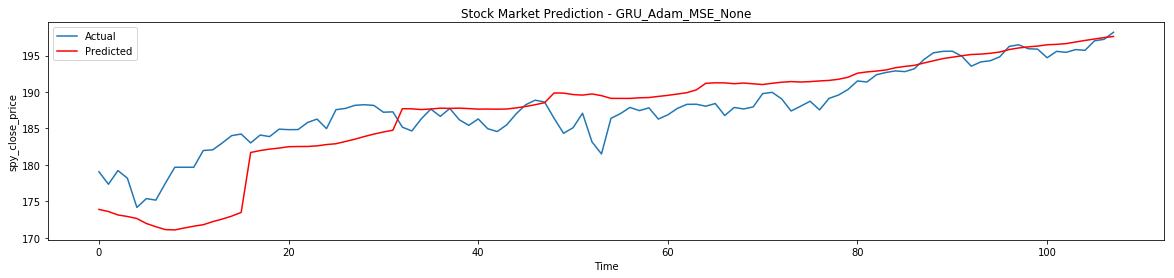

In [56]:
full_prediction(optimizer = 'Adam', loss = 'MSE', model_type = 'GRU', print_summary = False)

500 Epochs Finished. (Best: 500)

Model Evaluation: 
	Root mean squared error: 0.021036038041160245 
	Mean absolute error: 0.0170447465902


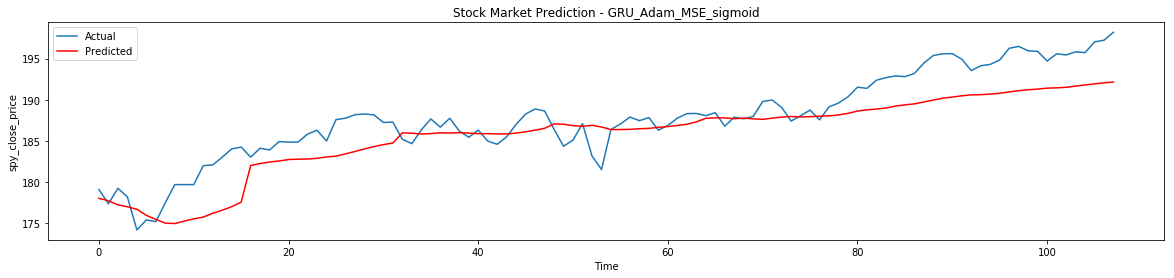

In [57]:
full_prediction(optimizer = 'Adam', loss = 'MSE', model_type = 'GRU', print_summary = False, activation='sigmoid')

500 Epochs Finished. (Best: 1)

Model Evaluation: 
	Root mean squared error: 0.41607573144059623 
	Mean absolute error: 0.414599876543


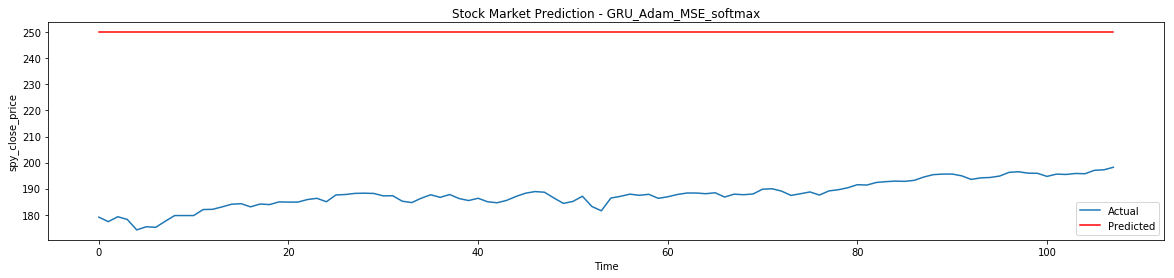

In [58]:
full_prediction(optimizer = 'Adam', loss = 'MSE', model_type = 'GRU', print_summary = False, activation='softmax')

---
#### Using Optimizer: RMSprop

500 Epochs Finished. (Best: 292)

Model Evaluation: 
	Root mean squared error: 0.02660074129531319 
	Mean absolute error: 0.018789336249


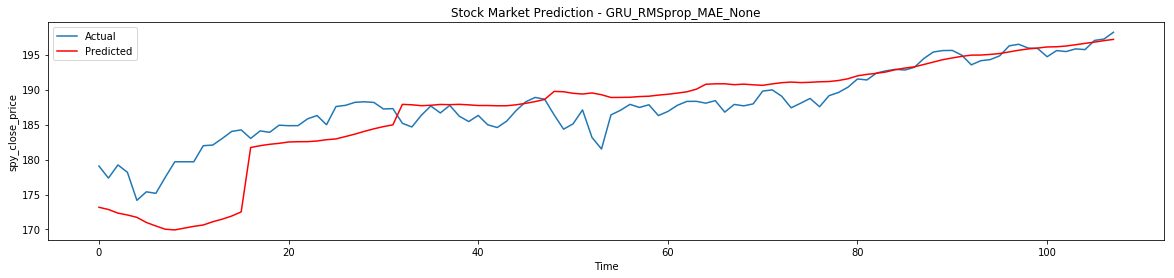

In [66]:
full_prediction(optimizer = 'RMSprop', loss = 'MAE', model_type = 'GRU', print_summary = False)

500 Epochs Finished. (Best: 500)

Model Evaluation: 
	Root mean squared error: 0.019927497177961866 
	Mean absolute error: 0.015222728771


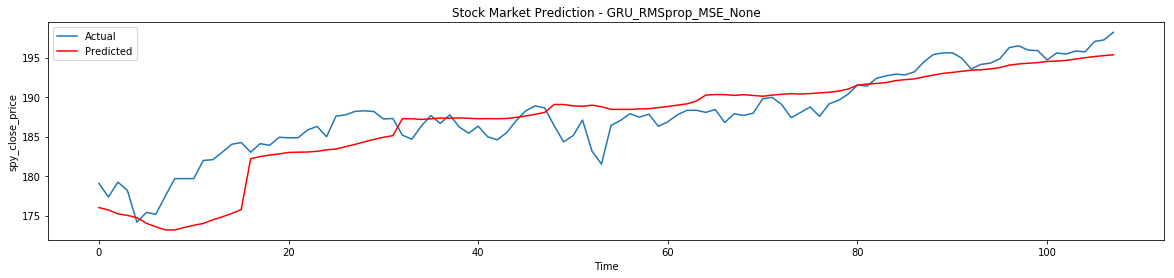

In [67]:
full_prediction(optimizer = 'RMSprop', loss = 'MSE', model_type = 'GRU', print_summary = False)

500 Epochs Finished. (Best: 486)

Model Evaluation: 
	Root mean squared error: 0.01678670822529621 
	Mean absolute error: 0.0132142133114


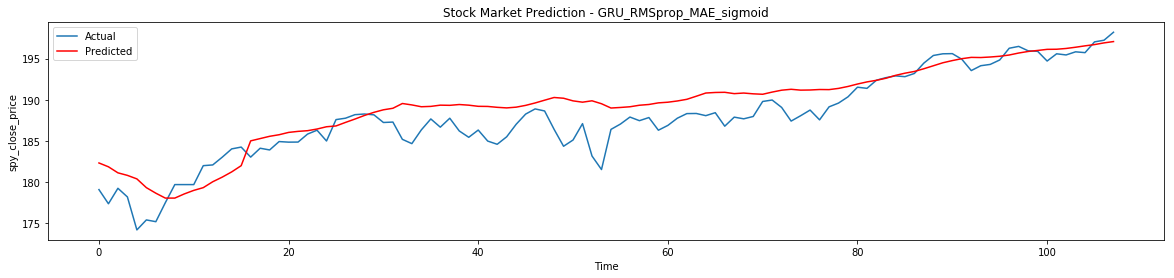

In [68]:
full_prediction(optimizer = 'RMSprop', loss = 'MAE', model_type = 'GRU', print_summary = False, activation='sigmoid')

---
## SimpleRNN

#### Using Optimizer: Adam

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (16, 10, 1)               0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (16, 10, 1)               3         
_________________________________________________________________
dense_25 (Dense)             (16, 10, 1)               2         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________

500 Epochs Finished. (Best: 245)

Model Evaluation: 
	Root mean squared error: 0.01915235370676499 
	Mean absolute error: 0.0156984451943


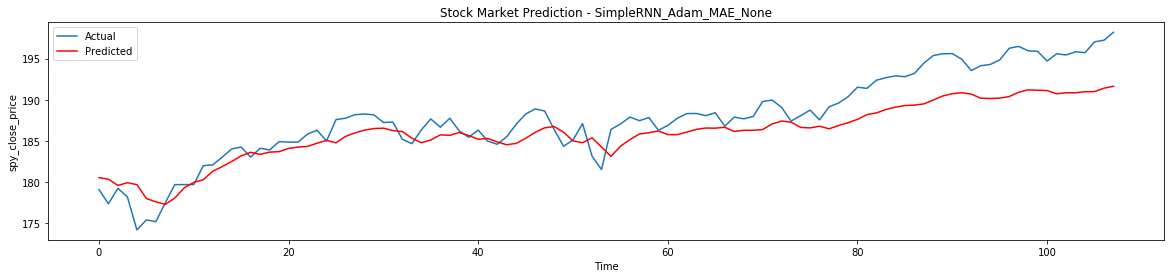

In [59]:
full_prediction(optimizer = 'Adam', loss = 'MAE', model_type = 'SimpleRNN')

500 Epochs Finished. (Best: 311)

Model Evaluation: 
	Root mean squared error: 0.008806765497161828 
	Mean absolute error: 0.00681669370478


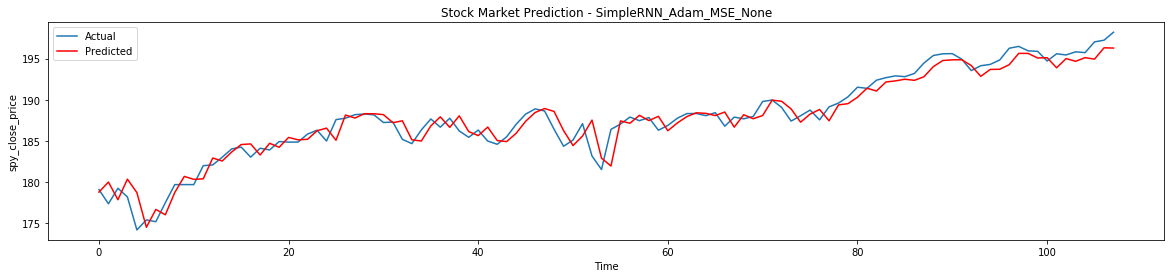

In [60]:
full_prediction(optimizer = 'Adam', loss = 'MSE', model_type = 'SimpleRNN', print_summary = False)

500 Epochs Finished. (Best: 500)

Model Evaluation: 
	Root mean squared error: 0.03758319683492802 
	Mean absolute error: 0.0332606751375


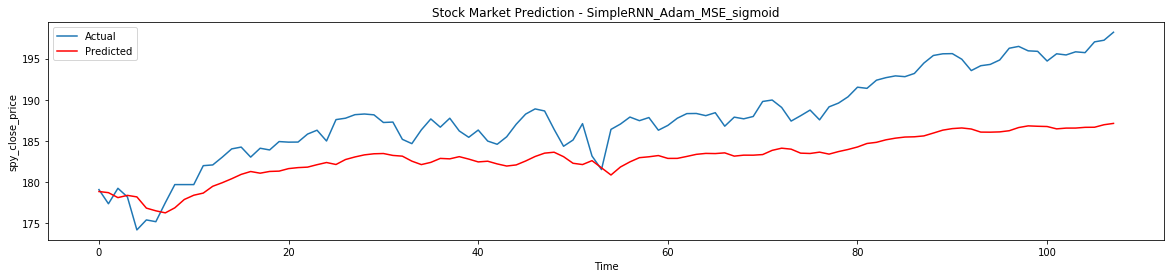

In [61]:
full_prediction(optimizer = 'Adam', loss = 'MSE', model_type = 'SimpleRNN', print_summary = False, activation = 'sigmoid')

500 Epochs Finished. (Best: 500)

Model Evaluation: 
	Root mean squared error: 0.01068857842152823 
	Mean absolute error: 0.00792100878009


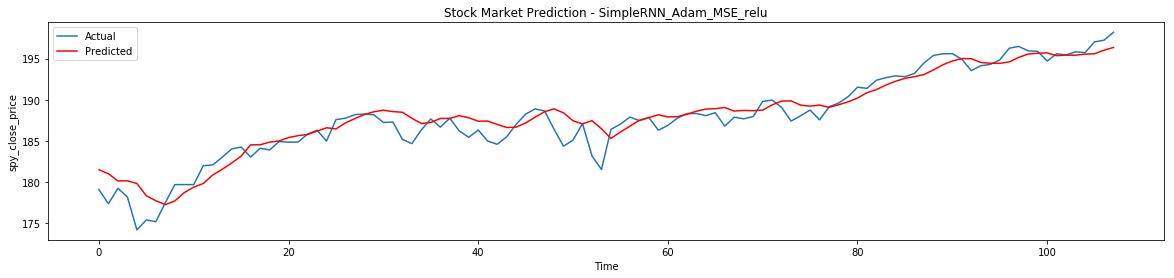

In [69]:
full_prediction(optimizer = 'Adam', loss = 'MSE', model_type = 'SimpleRNN', print_summary = False, activation = 'relu')

---
#### Using Optimizer: Adadelta

500 Epochs Finished. (Best: 480)

Model Evaluation: 
	Root mean squared error: 0.009285699836212084 
	Mean absolute error: 0.00668957671307


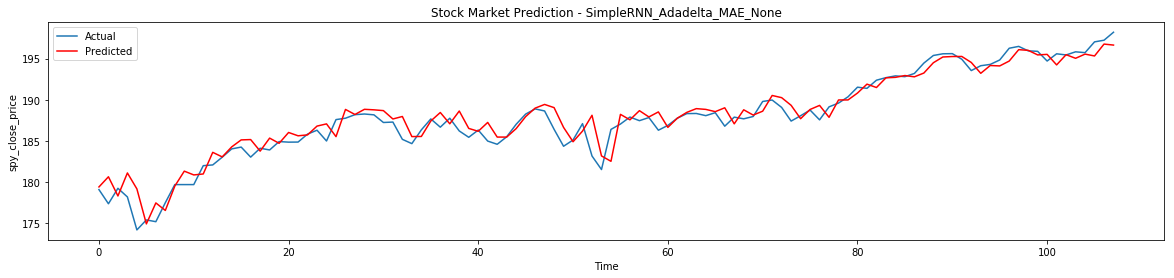

In [62]:
full_prediction(optimizer = 'Adadelta', loss = 'MAE', model_type = 'SimpleRNN', print_summary = False)

500 Epochs Finished. (Best: 500)

Model Evaluation: 
	Root mean squared error: 0.010401877838108503 
	Mean absolute error: 0.00769522811687


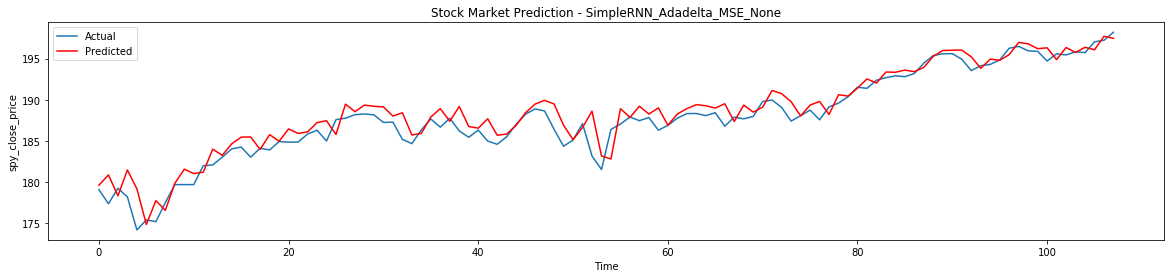

In [63]:
full_prediction(optimizer = 'Adadelta', loss = 'MSE', model_type = 'SimpleRNN', print_summary = False)

500 Epochs Finished. (Best: 500)

Model Evaluation: 
	Root mean squared error: 0.013973834362861438 
	Mean absolute error: 0.0110367235465


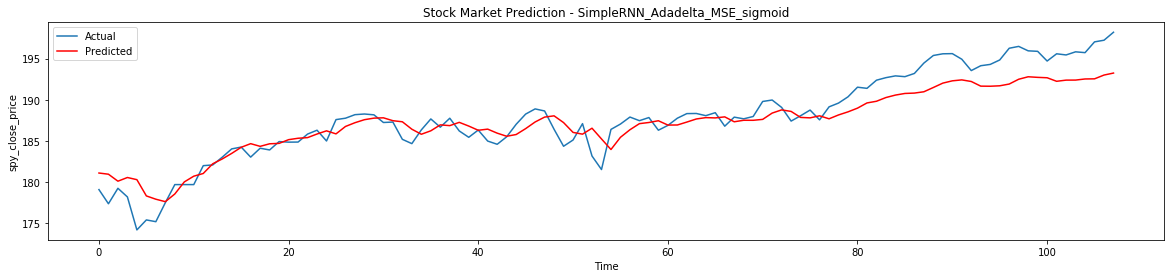

In [70]:
full_prediction(optimizer = 'Adadelta', loss = 'MSE', model_type = 'SimpleRNN', print_summary = False, activation = 'sigmoid')

500 Epochs Finished. (Best: 500)

Model Evaluation: 
	Root mean squared error: 0.015320341227736423 
	Mean absolute error: 0.0126159618182


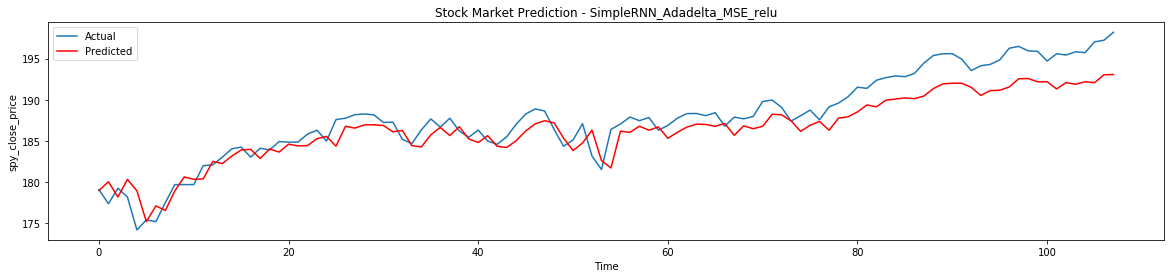

In [71]:
full_prediction(optimizer = 'Adadelta', loss = 'MSE', model_type = 'SimpleRNN', print_summary = False, activation = 'relu')

---
#### Using Optimizer: RMSprop

500 Epochs Finished. (Best: 500)

Model Evaluation: 
	Root mean squared error: 0.013061333988995514 
	Mean absolute error: 0.0105824815601


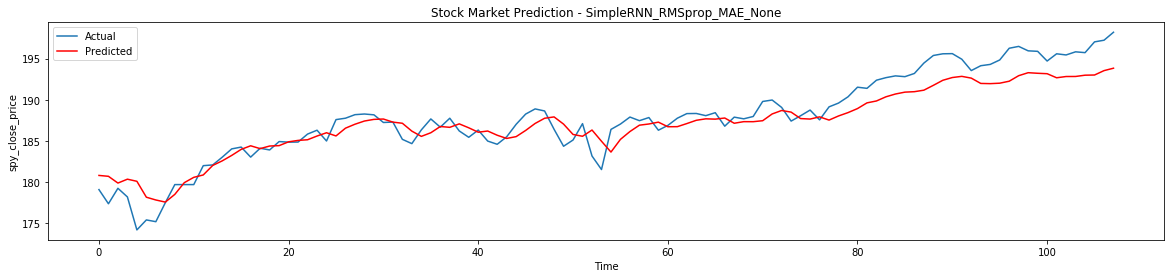

In [64]:
full_prediction(optimizer = 'RMSprop', loss = 'MAE', model_type = 'SimpleRNN', print_summary = False)

500 Epochs Finished. (Best: 500)

Model Evaluation: 
	Root mean squared error: 0.03520749611910426 
	Mean absolute error: 0.0305422968165


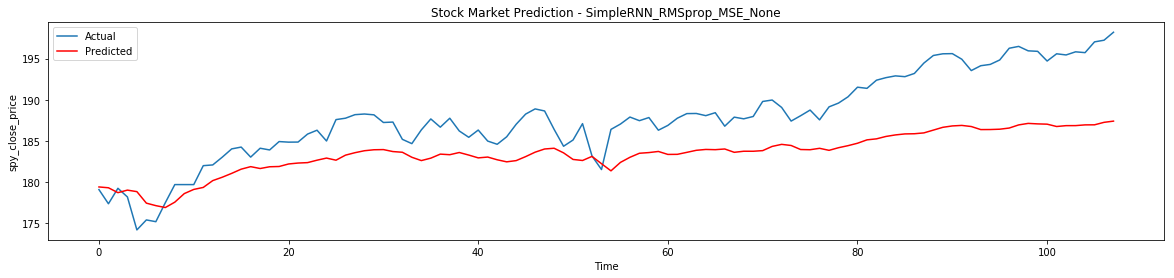

In [65]:
full_prediction(optimizer = 'RMSprop', loss = 'MSE', model_type = 'SimpleRNN', print_summary = False)

500 Epochs Finished. (Best: 500)

Model Evaluation: 
	Root mean squared error: 0.07898270123387358 
	Mean absolute error: 0.0741048558247


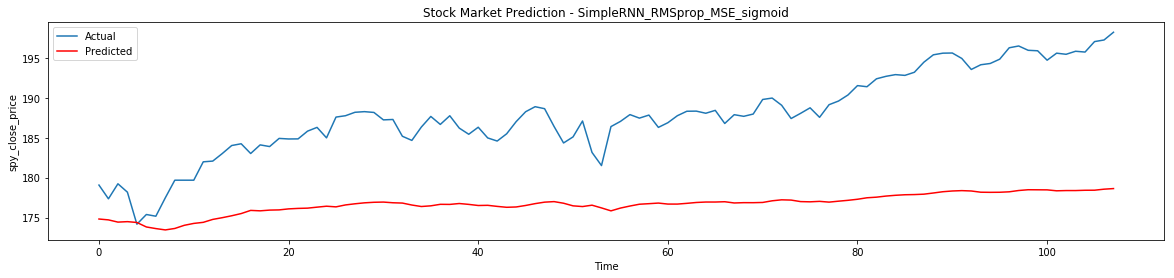

In [72]:
full_prediction(optimizer = 'RMSprop', loss = 'MSE', model_type = 'SimpleRNN', print_summary = False, activation='sigmoid')

500 Epochs Finished. (Best: 1)

Model Evaluation: 
	Root mean squared error: 0.5864462986560726 
	Mean absolute error: 0.585400123457


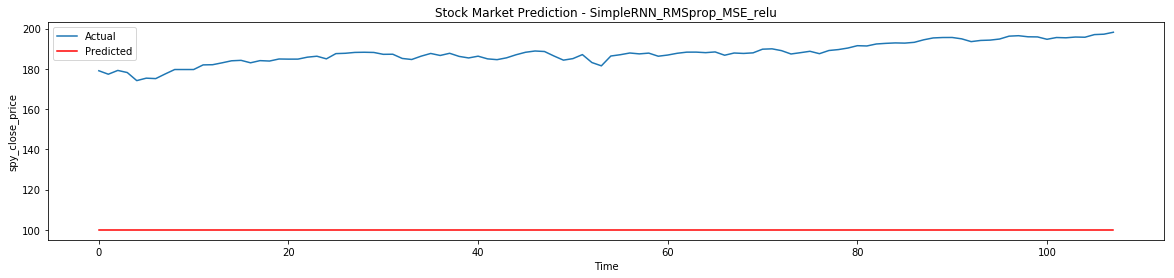

In [73]:
full_prediction(optimizer = 'RMSprop', loss = 'MSE', model_type = 'SimpleRNN', print_summary = False, activation='relu')

---
# Conclusion

### Part 1: Regression Models

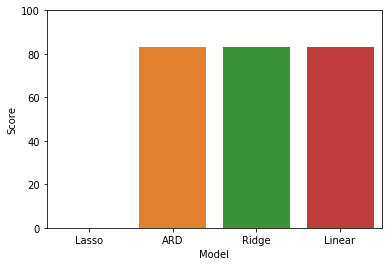

In [26]:
performance_df = pd.DataFrame(reg_performance).sort_values(by='Score')
plt.ylim(0, 100)
sns.barplot(data = performance_df, x='Model', y='Score')
plt.show()

#### *As can be seen from the plot, Linear, ARD and Ridge Regression model made good predictions, while Lasso Regression does poorly*

---
### Part 2: Neural Network

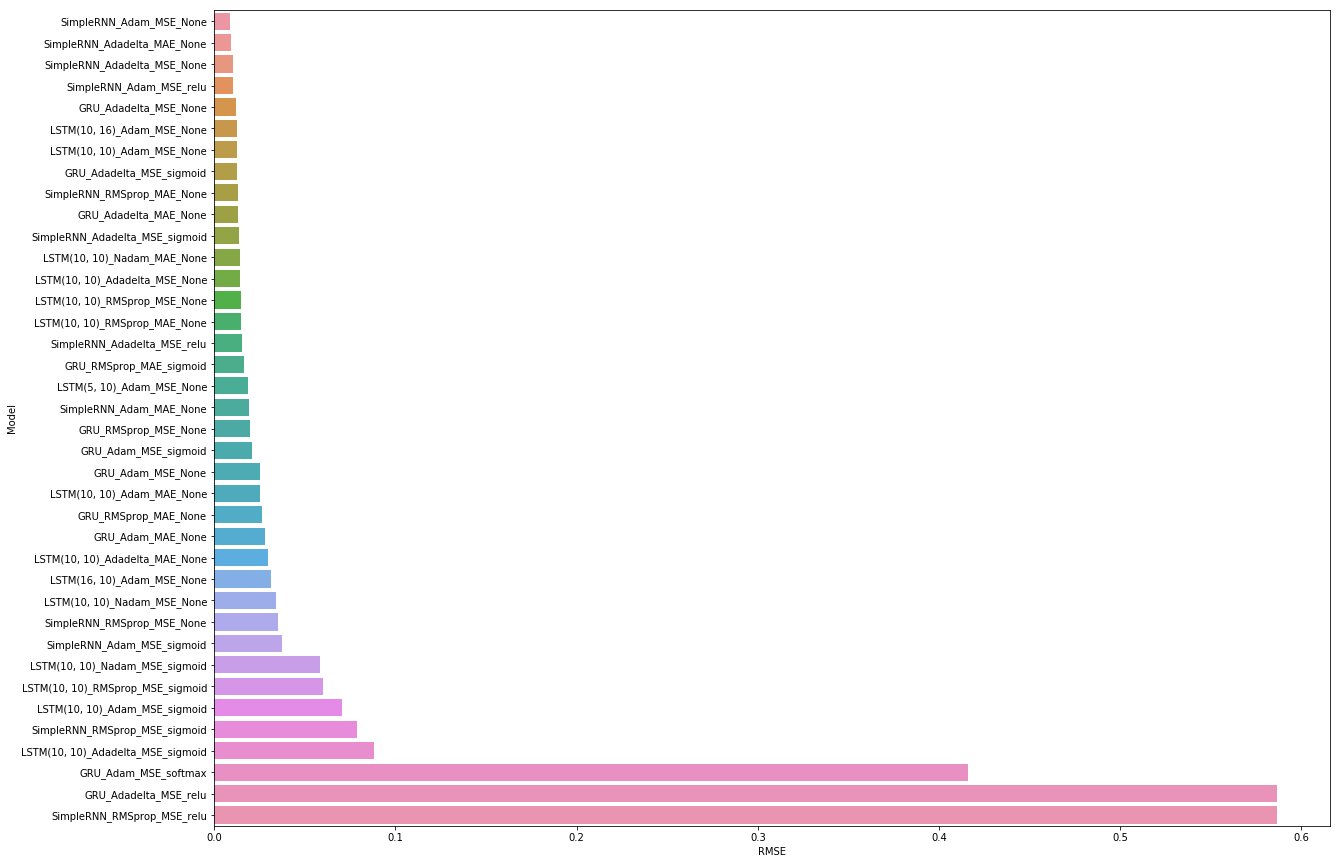

In [77]:
performance_df_rnn = pd.DataFrame(rnn_performance).sort_values(by='RMSE')
fig = plt.figure(figsize=(20, 15))
sns.barplot(data = performance_df_rnn, y='Model', x='RMSE')
plt.show()

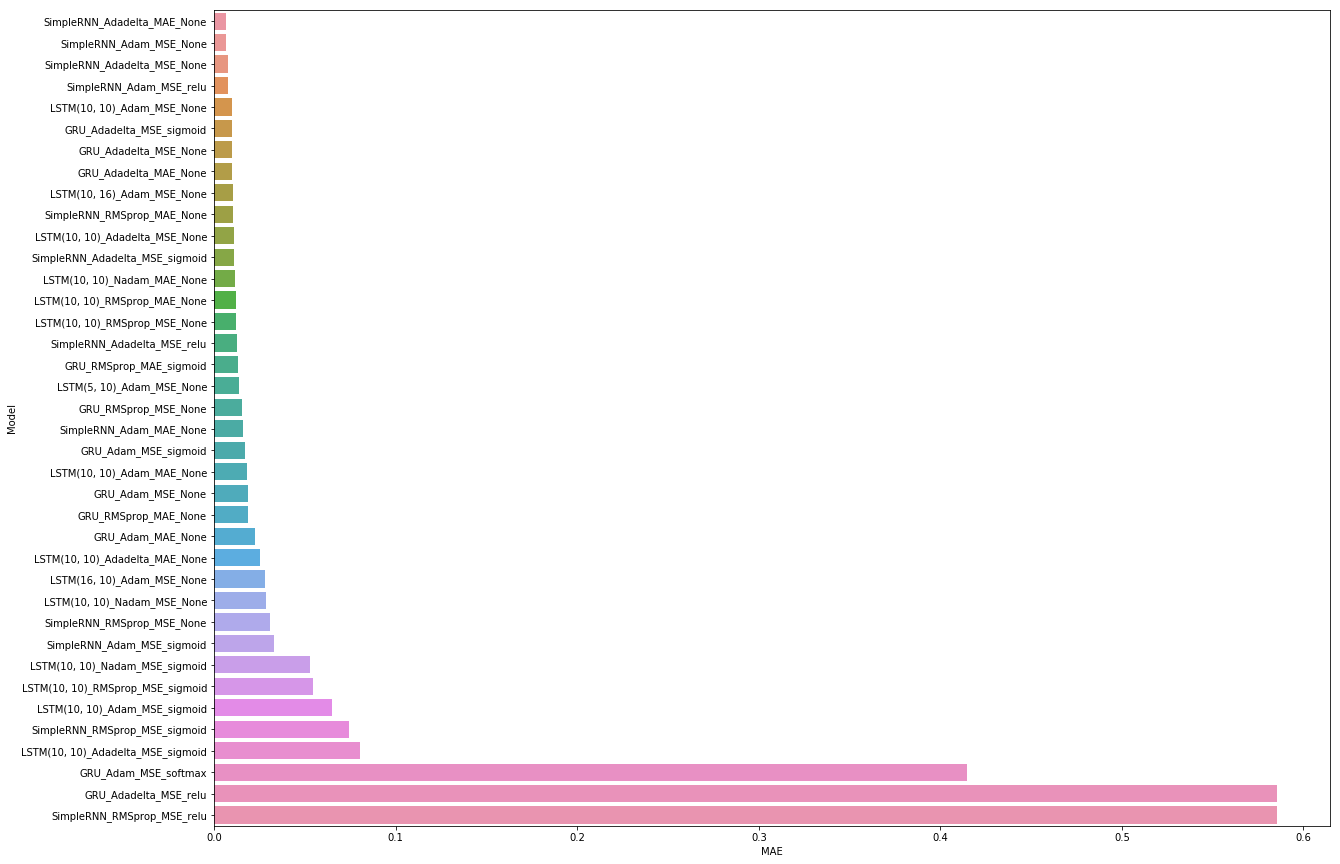

In [78]:
performance_df_rnn = performance_df_rnn.sort_values(by='MAE')
fig = plt.figure(figsize=(20, 15))
sns.barplot(data = performance_df_rnn, y='Model', x='MAE')
plt.show()

#### Best Model

500 Epochs Finished. (Best: 311)

Model Evaluation: 
	Root mean squared error: 0.008806765497161828 
	Mean absolute error: 0.00681669370478


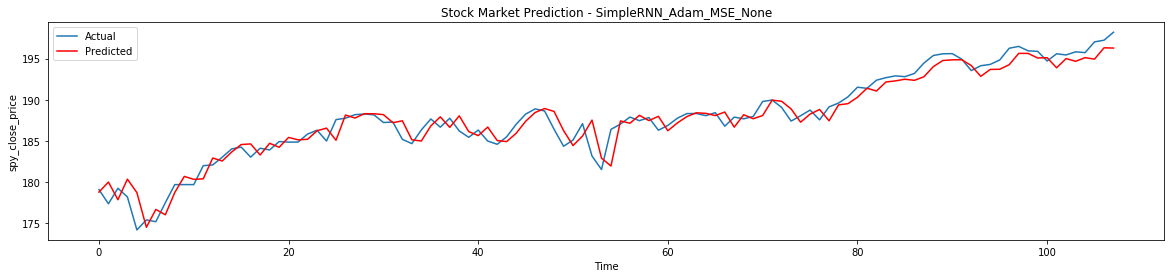

In [60]:
full_prediction(optimizer = 'Adam', loss = 'MSE', model_type = 'SimpleRNN', print_summary = False)

#### Summary
- Different loss functions may affect the model accuracy significantly
- It is important to choose a good optimizer for the model, here Adadelta and RMSprop performs better
- 500 epochs is large and takes a long time, but it do produce difference from my earlier experiment

#### Possible Future Experiments
- Change batch_size and/or timesteps
- Change number of layers
- Apply activation function to layers
- Try more optimizer and/or loss functions
- Apply the model on more recent data

---

*Last Update: Dec 9, 2018*